<a href="https://colab.research.google.com/github/markoraidlo/T14-Journey-to-zero/blob/main/NN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import pickle

## Kaggle

In [ ]:
# Kaggle setuo
from google.colab import files

files.upload(); # upload kaggle.json file

Saving kaggle.json to kaggle.json


In [ ]:
import json

# Use kaggle.json file
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!kaggle competitions download -c 'predict-electricity-consumption' -w

100% 174k/174k [00:00<00:00, 515kB/s]
100% 174k/174k [00:00<00:00, 514kB/s]


In [ ]:
!unzip predict-electricity-consumption.zip

Archive:  predict-electricity-consumption.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Preprocessing

In [ ]:
from sklearn import preprocessing
import pandas as pd

def preprocess(trainDF, testDF, previous_hours=None):
  """ Take train and test datasets at the same time
  """

  # Remove row if consumption is NaN
  # (Only for training data)
  trainDF = trainDF.dropna(subset=['consumption'])

  
  # scaler for consumption
  normScaler = preprocessing.MinMaxScaler()
  normScaler.fit(trainDF[['consumption']])
  trainDF['consumption'] = normScaler.transform(trainDF[['consumption']])

  # Add n previous hour features
  if previous_hours:
    for i in range(1, previous_hours+1):
      trainDF['{}cons'.format(i)] = trainDF.consumption.shift(i)
    
    # Cut out first n rows with NaNs
    trainDF = trainDF[previous_hours:]

  # All remaning NaNs replaced with 0
  trainDF = trainDF.fillna(0)
  testDF = testDF.fillna(0)

  # Get weekday, month and hour of day
  trainDF['time'] = pd.to_datetime(trainDF.time, utc=True)
  trainDF['time'] = trainDF['time'].dt.tz_convert('Europe/Tallinn')
  trainDF['day'] = trainDF['time'].dt.weekday
  trainDF['month'] = trainDF['time'].dt.month
  trainDF['hour'] = trainDF['time'].dt.hour

  testDF['time'] = pd.to_datetime(testDF.time, utc=True)
  testDF['time'] = testDF['time'].dt.tz_convert('Europe/Tallinn')
  testDF['day'] = testDF['time'].dt.weekday
  testDF['month'] = testDF['time'].dt.month
  testDF['hour'] = testDF['time'].dt.hour

  # Normalization
  colList = ['temp', 'dwpt','rhum', 'wdir', 'wspd', 'wpgt', 'pres', 'el_price']

  for col in colList:
    scaler = preprocessing.MinMaxScaler()
    normCol = scaler.fit_transform(trainDF[[col]])
    trainDF[col] = normCol
    testDF[col] = scaler.transform(testDF[[col]])

  # One hot encoding days
  onehot_days = pd.get_dummies(trainDF['day'])
  onehot_days = onehot_days.set_axis(['Monday', 'Tuesday', 'Wendesday', 
                                      'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1)
  trainDF = trainDF.join(onehot_days)

  onehot_days = pd.get_dummies(testDF['day'])
  onehot_days = onehot_days.set_axis(['Monday', 'Tuesday', 'Wendesday', 
                                      'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1)
  testDF = testDF.join(onehot_days)
  
  # One hot encoding days
  onehot_hours = pd.get_dummies(trainDF['hour'])
  hour_cols = ["{}hour".format(i) for i in range(24)]
  onehot_hours = onehot_hours.set_axis(hour_cols, axis=1)
  trainDF = trainDF.join(onehot_hours)

  onehot_hours = pd.get_dummies(testDF['hour'])
  onehot_hours = onehot_hours.set_axis(hour_cols, axis=1)
  testDF = testDF.join(onehot_hours)


  #TODO: Onehot months
  #TODO: Onehot coco

  # If one-hot vecencodingtor is done remove:
  scaler = preprocessing.MinMaxScaler()
  normCol = scaler.fit_transform(trainDF[['month']])
  trainDF['month'] = normCol
  testDF['month'] = scaler.transform(testDF[['month']])

  # Sin and cos of hours and days
  trainDF['sin_hour'] = np.sin(2*np.pi*(trainDF['hour'])/24)
  trainDF['cos_hour'] = np.cos(2*np.pi*(trainDF['hour'])/24)   
  trainDF['sin_day'] = np.sin(2*np.pi*(trainDF['day'])/7)
  trainDF['cos_day'] = np.cos(2*np.pi*(trainDF['day'])/7) 

  testDF['sin_hour'] = np.sin(2*np.pi*(testDF['hour'])/24)
  testDF['cos_hour'] = np.cos(2*np.pi*(testDF['hour'])/24)   
  testDF['sin_day'] = np.sin(2*np.pi*(testDF['day'])/7)
  testDF['cos_day'] = np.cos(2*np.pi*(testDF['day'])/7) 


  trainDF = trainDF.drop(columns=['day', 'hour', 'coco'])
  testDF = testDF.drop(columns=['day', 'hour', 'coco'])
  # And add:
  #processedDataFrame = dataFrame.drop(columns=['day', 'month', 'hour']

  return trainDF, testDF, normScaler

In [ ]:
train =  pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')

In [ ]:
pro_train, pro_test, normScaler = preprocess(train ,test, 24)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Consumption shift predictions

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
pro_train.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'el_price', 'consumption', '1cons', '2cons', '3cons', '4cons',
       '5cons', '6cons', '7cons', '8cons', '9cons', '10cons', '11cons',
       '12cons', '13cons', '14cons', '15cons', '16cons', '17cons', '18cons',
       '19cons', '20cons', '21cons', '22cons', '23cons', '24cons', 'month',
       'Monday', 'Tuesday', 'Wendesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', '0hour', '1hour', '2hour', '3hour', '4hour', '5hour', '6hour',
       '7hour', '8hour', '9hour', '10hour', '11hour', '12hour', '13hour',
       '14hour', '15hour', '16hour', '17hour', '18hour', '19hour', '20hour',
       '21hour', '22hour', '23hour', 'sin_hour', 'cos_hour', 'sin_day',
       'cos_day'],
      dtype='object')

In [ ]:
X = pro_train[['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'el_price', 'month',
       'Monday', 'Tuesday', 'Wendesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', '0hour', '1hour', '2hour', '3hour', '4hour', '5hour', '6hour',
       '7hour', '8hour', '9hour', '10hour', '11hour', '12hour', '13hour',
       '14hour', '15hour', '16hour', '17hour', '18hour', '19hour', '20hour',
       '21hour', '22hour', '23hour', 'sin_hour', 'cos_hour', 'sin_day',
       'cos_day', '1cons', '2cons', '3cons', '4cons',
       '5cons', '6cons', '7cons', '8cons', '9cons', '10cons', '11cons',
       '12cons', '13cons', '14cons', '15cons', '16cons', '17cons', '18cons',
       '19cons', '20cons', '21cons', '22cons', '23cons', '24cons']]
y = pro_train[['consumption']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, shuffle=False)

neural_net = MLPRegressor(max_iter=1000000,
                         solver = 'adam',
                         activation = 'relu').fit(X_train, y_train.ravel())


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
X_test = pro_test[['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'el_price', 'month',
       'Monday', 'Tuesday', 'Wendesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', '0hour', '1hour', '2hour', '3hour', '4hour', '5hour', '6hour',
       '7hour', '8hour', '9hour', '10hour', '11hour', '12hour', '13hour',
       '14hour', '15hour', '16hour', '17hour', '18hour', '19hour', '20hour',
       '21hour', '22hour', '23hour', 'sin_hour', 'cos_hour', 'sin_day',
       'cos_day']]

test_pred = np.zeros(len(pro_test))
previous = pro_train.iloc[-1][['1cons', '2cons', '3cons', '4cons', '5cons', '6cons', '7cons',
                    '8cons', '9cons', '10cons', '11cons', '12cons', '13cons', '14cons',
                  '15cons', '16cons', '17cons', '18cons', '19cons', '20cons', '21cons',
                  '22cons', '23cons', '24cons']]


for i in range(len(pro_test)):
  prediction = neural_net.predict([X_test.iloc[i].append(previous)])
  test_pred[i] = prediction
  previous = previous.shift(1)
  previous[0] = prediction

#test_pred
pred = normScaler.inverse_transform([test_pred])
pred

array([[ 1.58200755e+00,  3.09503681e-01,  4.03202570e-02,
        -4.66911354e-02, -2.06949764e-02, -3.22818493e-01,
        -3.03763779e-01,  2.99231463e-01, -6.29356490e-03,
         7.65755646e-02, -1.74228453e-01, -2.58424729e-01,
        -6.95910249e-02,  5.58130882e-02,  4.48971390e-01,
        -3.26527700e-01, -2.27573674e-01,  2.62329498e-02,
        -2.11848481e-01,  4.37403896e-01,  2.19926291e-01,
         4.82708119e-01,  1.00781899e-01, -3.55135203e-01,
         1.11602186e-01, -1.05135412e-01,  4.52881181e-01,
         6.00802037e-01,  8.76154370e-01,  2.17683946e-01,
        -2.91576689e-01, -5.10804802e-02,  1.10881832e-01,
        -1.71445806e-03, -4.98585965e-01, -8.19985515e-01,
        -8.42683548e-01, -9.95730527e-01, -4.74059860e-01,
        -5.23744411e-01, -5.96607549e-01,  2.32441295e-01,
         3.41090319e-01,  3.82465344e-01,  1.32537150e-01,
        -1.83695258e-01,  2.12451710e-01,  1.64726582e-01,
         4.83921877e-01,  5.23214875e-01,  3.41146458e-0

In [ ]:
submission = pd.DataFrame(
    {'time': pro_test.time, 'consumption': pred[0]},
    columns = ['time', 'consumption'])
submission.to_csv('NN_multivar_submission.csv', index = False)

In [ ]:
!kaggle competitions submit -c predict-electricity-consumption -f NN_multivar_submission.csv -m "MLPRegressor with multivariable data."

100% 7.52k/7.52k [00:02<00:00, 3.69kB/s]
Successfully submitted to Journey to zero - Predict electricity consumption

## Tensorflow: Long Short Term Memory model

In [ ]:
import tensorflow as tf

In [ ]:
X = pro_train[['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'el_price', 'month',
       'Monday', 'Tuesday', 'Wendesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', '0hour', '1hour', '2hour', '3hour', '4hour', '5hour', '6hour',
       '7hour', '8hour', '9hour', '10hour', '11hour', '12hour', '13hour',
       '14hour', '15hour', '16hour', '17hour', '18hour', '19hour', '20hour',
       '21hour', '22hour', '23hour', 'sin_hour', 'cos_hour', 'sin_day',
       'cos_day']]
y = pro_train[['consumption']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=False)

In [ ]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=168,
    sampling_rate=1,
    sequence_stride=1
)

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=168,
    sampling_rate=1,
    sequence_stride=1
)

In [ ]:
for batch in dataset_val.take(1):
    inputs, targets = batch

In [ ]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 168, 46)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                10112     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,145
Trainable params: 10,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_val)

Epoch 1/20
46/46 [==============================] - 9s 153ms/step - loss: 0.0832 - val_loss: 0.0537
Epoch 2/20
46/46 [==============================] - 6s 141ms/step - loss: 0.0384 - val_loss: 0.0279
Epoch 3/20
46/46 [==============================] - 6s 141ms/step - loss: 0.0268 - val_loss: 0.0219
Epoch 4/20
46/46 [==============================] - 6s 140ms/step - loss: 0.0220 - val_loss: 0.0189
Epoch 5/20
46/46 [==============================] - 6s 140ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 6/20
46/46 [==============================] - 6s 141ms/step - loss: 0.0179 - val_loss: 0.0157
Epoch 7/20
46/46 [==============================] - 7s 142ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 8/20
46/46 [==============================] - 7s 144ms/step - loss: 0.0158 - val_loss: 0.0139
Epoch 9/20
46/46 [==============================] - 7s 146ms/step - loss: 0.0151 - val_loss: 0.0133
Epoch 10/20
46/46 [==============================] - 7s 144ms/step - loss: 0.0146 - val_loss: 0.0128

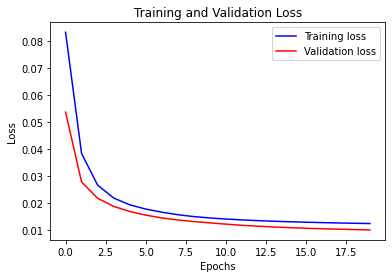

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [ ]:
X_kag = pro_test[['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'el_price', 'month',
       'Monday', 'Tuesday', 'Wendesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', '0hour', '1hour', '2hour', '3hour', '4hour', '5hour', '6hour',
       '7hour', '8hour', '9hour', '10hour', '11hour', '12hour', '13hour',
       '14hour', '15hour', '16hour', '17hour', '18hour', '19hour', '20hour',
       '21hour', '22hour', '23hour', 'sin_hour', 'cos_hour', 'sin_day',
       'cos_day']]

dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_kag,
    np.zeros(len(X_kag)),
    sequence_length=168,
    sampling_rate=1,
    sequence_stride=1
)
x_test = dataset_test.as_numpy_iterator()

print(model.predict(x_test))

1/1 [==============================] - 1s 505ms/step
[[0.15368918]]


## Basic CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential

In [ ]:
model = Sequential()

model.add(Dense(64,activation='relu', input_dim=(46)))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse') 

In [ ]:
batch_size = 168
epochs = 100

history2 = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
36/36 [==============================] - 0s 13ms/step - loss: 0.4670 - val_loss: 0.5214
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.4201 - val_loss: 0.5052
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.3984 - val_loss: 0.4948
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 0.3811 - val_loss: 0.4782
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.3697 - val_loss: 0.4658
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 0.3451 - val_loss: 0.4479
Epoch 7/100
36/36 [==============================] - 0s 11ms/step - loss: 0.3261 - val_loss: 0.4404
Epoch 8/100
36/36 [==============================] - 1s 14ms/step - loss: 0.3117 - val_loss: 0.4170
Epoch 9/100
36/36 [==============================] - 1s 15ms/step - loss: 0.3061 - val_loss: 0.4002
Epoch 10/100
36/36 [==============================] - 0s 11ms/step - loss: 0.2877 - val_loss: 0.3801

In [ ]:
test_pred = model.predict(X_kag)

pred = normScaler.inverse_transform(test_pred)
np.shape(pred.flatten())

6/6 [==============================] - 0s 4ms/step


(168,)

In [ ]:
submission = pd.DataFrame(
    {'time': pro_test.time, 'consumption': pred.flatten()},
    columns = ['time', 'consumption'])
submission.to_csv('Dense_NN.csv', index = False)

In [ ]:
!kaggle competitions submit -c predict-electricity-consumption -f Dense_NN.csv -m "Tensorflow dense model predictions."

100% 5.95k/5.95k [00:02<00:00, 2.57kB/s]
Successfully submitted to Journey to zero - Predict electricity consumption